In [2]:
import sys

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

sys.path.insert(1, '/mnt/c/Users/Tiz/PycharmProjects/SBFBenchmark/')
from FieldTranslator.AdienceForRor34 import AdienceForRor34

adience_chunks = [
    pd.read_csv("/mnt/c/Users/Tiz/PycharmProjects/SBFBenchmark/out/ror34_AgeAndGender_adience/Adience_chunk_0.csv", index_col=[0]),
    pd.read_csv("/mnt/c/Users/Tiz/PycharmProjects/SBFBenchmark/out/ror34_AgeAndGender_adience/Adience_chunk_1.csv", index_col=[0]),
    pd.read_csv("/mnt/c/Users/Tiz/PycharmProjects/SBFBenchmark/out/ror34_AgeAndGender_adience/Adience_chunk_2.csv", index_col=[0]),
    pd.read_csv("/mnt/c/Users/Tiz/PycharmProjects/SBFBenchmark/out/ror34_AgeAndGender_adience/Adience_chunk_3.csv", index_col=[0]),
    pd.read_csv("/mnt/c/Users/Tiz/PycharmProjects/SBFBenchmark/out/ror34_AgeAndGender_adience/Adience_chunk_4.csv", index_col=[0]),
]

for c in adience_chunks:
    c.drop(['img_path'], inplace=True, axis=1)

value_name = 'age'
bucket_prefix = 'bucket_'

detector_name = 'RoR-34'
detector_prefix = 'ror34_'
detector_gt_prefix = 'ror34_gt_'
detector_bucket_count = 4

df = pd.concat([adience_chunks[0], adience_chunks[1], adience_chunks[2], adience_chunks[3], adience_chunks[4]])
df = AdienceForRor34().append_translated(df)
df

,age,gender,ror34_age,ror34_gender,ror34_gt_age,ror34_gt_gender
0,"(25, 32)",f,"(50 , 74)",f,"(25 , 49)",f
1,"(25, 32)",m,"(50 , 74)",m,"(25 , 49)",m
2,"(25, 32)",f,"(50 , 74)",m,"(25 , 49)",f
3,"(25, 32)",m,"(75 , 99)",m,"(25 , 49)",m
4,"(25, 32)",m,"(50 , 74)",m,"(25 , 49)",m
...,...,...,...,...,...,...
3811,None,NaN,"(25 , 49)",m,None,NaN
3812,None,NaN,"(25 , 49)",f,None,NaN
3813,None,NaN,"(50 , 74)",f,None,NaN
3814,None,NaN,"(25 , 49)",m,None,NaN


In [3]:
# Compare match results
df[value_name+'_match'] =  df.apply(lambda row: row[detector_gt_prefix+value_name]==row[detector_prefix+value_name], axis=1)


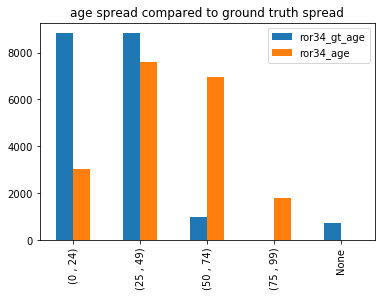

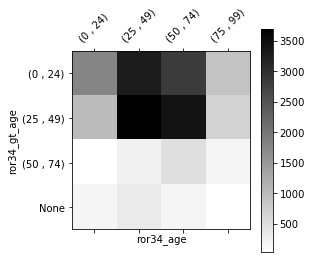

In [4]:
# Show age spread compared to ground truth age spread
s1 = df[detector_gt_prefix+value_name].value_counts()
s2 = df[detector_prefix+value_name].value_counts()
counts_df = pd.merge(s1, s2, right_index = True,left_index = True, how='outer').fillna(0)


prediction_spread = counts_df.plot(kind='bar', title=value_name+' spread compared to ground truth spread')
df_confusion = pd.crosstab(df[detector_gt_prefix+value_name], df[detector_prefix+value_name])


def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

In [5]:
# Accuracy
match_df = df[value_name+'_match'].value_counts()
total_match_count = match_df[True] + match_df[False]
accuracy = match_df[True] / total_match_count * 1
baseline_accuracy = 1 / df[detector_prefix+value_name].value_counts().shape[0]
accuracy_over_random_chance = accuracy - baseline_accuracy
accuracy_score = round(accuracy_over_random_chance / (1 - baseline_accuracy) * 1000)

result_df = pd.DataFrame({
    'name': [detector_name],
    'dataset': ['Adience'],
    'value':[value_name],
    'bucket_count': [detector_bucket_count],
    'accuracy': [accuracy],
    'baseline_accuracy': [baseline_accuracy],
    'accuracy_over_random_chance': [accuracy_over_random_chance],
    'accuracy_score': [accuracy_score]
})

In [6]:
from pandas import Series

bucket_to_error = {
    "(0 , 24)": 0,
    "(25 , 49)": 1,
    "(50 , 74)": 2,
    "(75 , 99)": 3,
}

# MAE (Mean Absolute Error)
def _error_mapping(value: str) -> int:
    return bucket_to_error[value]

df.filter([detector_prefix+value_name, detector_gt_prefix+value_name, value_name+'_match'])
df = df[df.ror34_gt_age != "None"]
df[bucket_prefix+detector_prefix+value_name] = df.apply(lambda row: _error_mapping(row[detector_prefix+value_name]), axis=1)
df[bucket_prefix+detector_gt_prefix+value_name] = df.apply(lambda row: _error_mapping(row[detector_gt_prefix+value_name]), axis=1)
df['error'] = df.apply(lambda row: abs(row[bucket_prefix+detector_gt_prefix+value_name] - row[bucket_prefix+detector_prefix+value_name]), axis=1)
MAE = df['error'].sum() / df.shape[0]
normalized_MAE = MAE / (detector_bucket_count - 1)

print(f"The prediction is expected to be {MAE:0.2} buckets of the actual bucket.")
print(f"(normalized: {normalized_MAE:0.2})")

The prediction is expected to be 0.97 buckets of the actual bucket.
(normalized: 0.32)


,name,dataset,value,score,accuracy_score,MAE_score,bucket_count,accuracy,baseline_accuracy,accuracy_over_random_chance,MAE,normalized_MAE
0,RoR-34,Adience,age,757.0,79.0,678.0,4,0.309448,0.25,0.059448,0.966115,0.322038


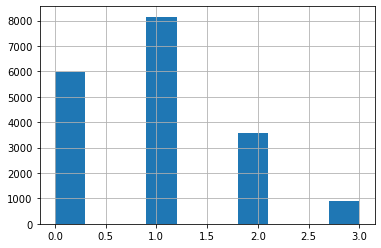

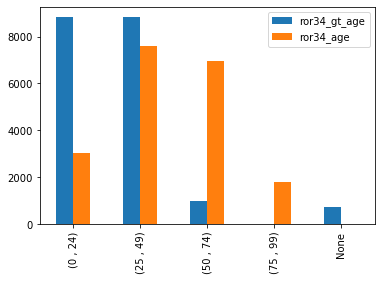

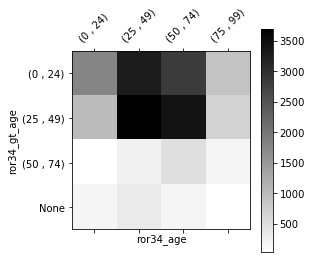

In [7]:
result_df['MAE'] = [MAE]
result_df['normalized_MAE'] = [normalized_MAE]
result_df['MAE_score'] = round((1 - normalized_MAE) * 1000)
result_df['score'] = result_df.apply(lambda row: row['accuracy_score'] + row['MAE_score'], axis=1)
result_df = result_df[['name', 'dataset', 'value', 'score', 'accuracy_score', 'MAE_score', 'bucket_count', 'accuracy', 'baseline_accuracy', 'accuracy_over_random_chance', 'MAE', 'normalized_MAE']]

absolute_error_hist = df['error'].hist()
counts_df.plot(kind='bar')
plot_confusion_matrix(df_confusion)
result_df